# FANTASY AGN Tutorial

Student: Ridha Fathima Mohideen Malik

Instructor: Dragana Ilic

Task for MASS students, March 29, 2023:
1. take one of the given example of type 1 AGN from SDSS (or find any other example quasar spectrum from the SDSS);
2. run the procedure for quasar spectra decomposition as described in this tutorial;
3. measure the line fluxes in narrow Ha, Hb, [OIII], [NII] and [SII] lines if present;
4. measure the line fluxes in broad Ha, Hb;
5. calculate the line ratios ([NII]6583/Ha, [OIII]5007/Hb) and check where they stand on BPT diagrams; if there is a host galaxy contribution, measure these ratios on non-corrected (i.e. observed) spectrum and compare the results;
6. measure the Ha/Hb ratio in the observed and host-galaxy corrected spectra, and compare.
7. share your jupyter notebook with results and comments.

In [24]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from fantasy_agn.tools import read_sdss
from fantasy_agn.models import create_input_folder, continuum, create_fixed_model, create_tied_model, create_feii_model, create_line

## Preparing spectrum

In [25]:
# Reading spectrum, correcting for galactic extinction and redshift

s = read_sdss('spec-0650-52143-0279.fits')
s.DeRedden()
s.CorRed()

### Host fitting

In [26]:
# host fitting and substraction

s.fit_host_sdss(mask_host=False, custom=False)

Host contribution is negliglable


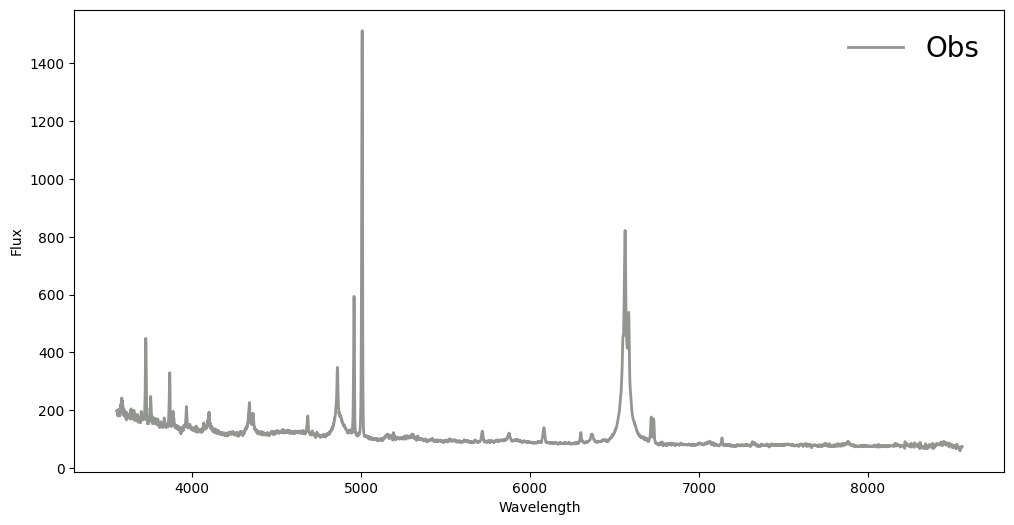

In [27]:
# plot

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.xlabel(r"Wavelength")
plt.ylabel(r"Flux")
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)

Notes on observed spectrum:

* No prominent absorption lines
* Relatively weak blue continuum

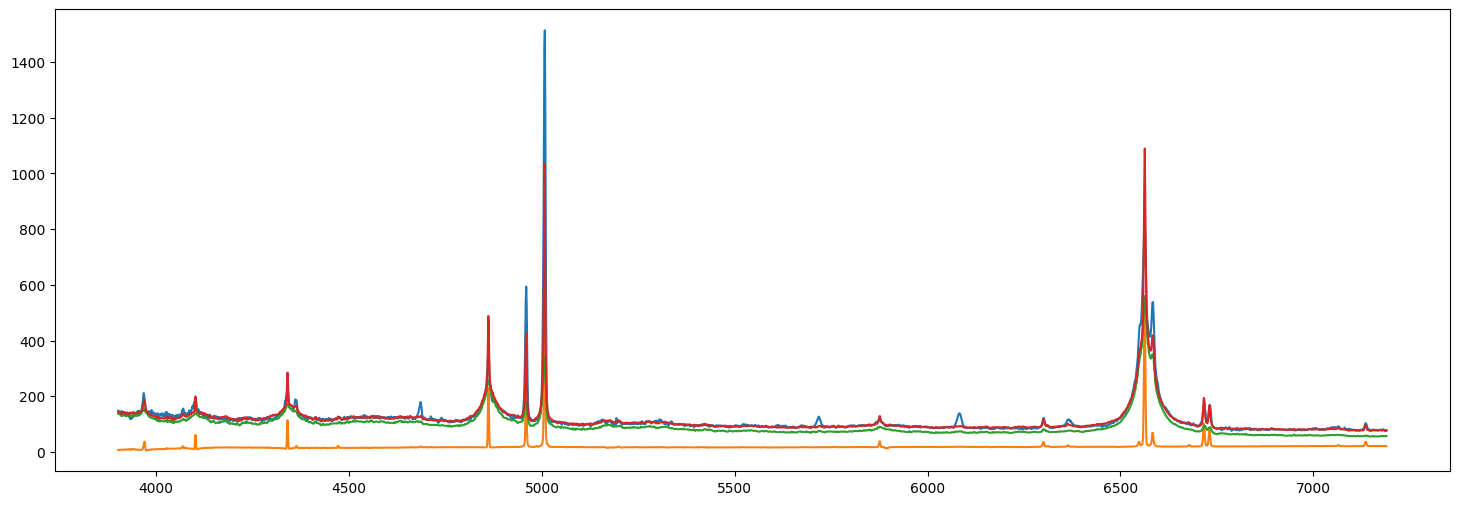

In [28]:
s.restore()
s.crop(3900,8000)
s.fit_host_sdss(mask_host=False, custom=False)

Notes on the plot:
* Blue line - observation
* Green line - AGN model
* Orange line - host model
* Red line - AGN+host model

A comment on package:
* Output legend needs to be added to the package.

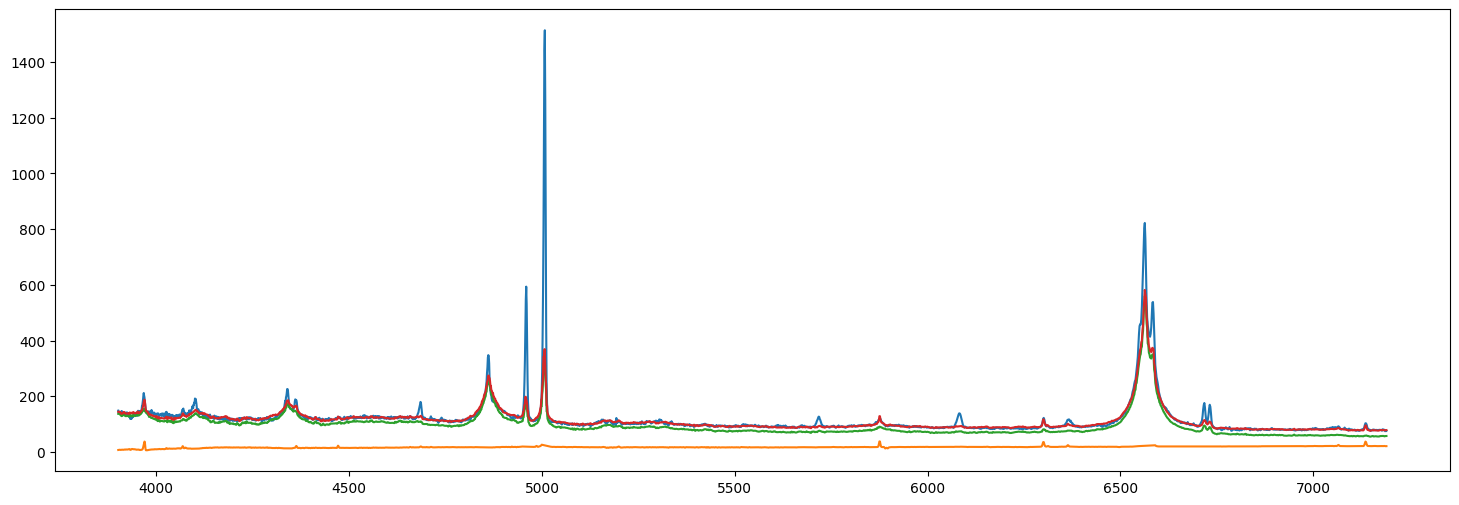

In [29]:
s.host_no_mask=s.host
s.restore()
s.fit_host_sdss(mask_host=True, custom=False)

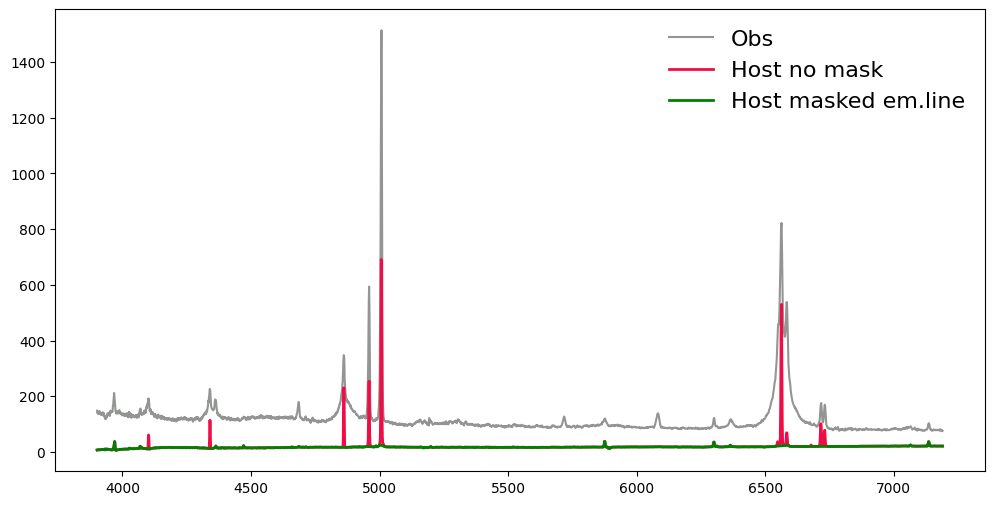

In [30]:
# comparing host-fitting results

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux+s.host, color="#929591", label='Obs' , lw=1.5)
plt.plot(s.wave, s.host_no_mask, color="#F10C45", label='Host no mask', lw=2)
plt.plot(s.wave, s.host, color="green", label='Host masked em.line', lw=2)
plt.legend(loc='upper right',  prop={'size': 16}, frameon=False)


Notes on host fitting:
* Host has neglibible contribution to the continuum in the cropped spectrum
* Host has strong narrow emission lines

## Defining the fitting model

In [31]:
# plotly interactive plot to inspect the lines

fig = px.line(x=s.wave, y=s.flux+s.host)
fig.update_layout(
    title="Observed",
    xaxis_title="Wavelength",
    yaxis_title="Flux",
    )
fig.show()

In [32]:
create_input_folder(xmin=3500,xmax=8000, path_to_folder='lines/')

Directory  lines/  already exists


In [33]:
# lines added to the model based on https://physics.nist.gov/PhysRefData/ASD/lines_form.html

cont = continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad = create_fixed_model(['hydrogen.csv'], name='br')
he = create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow = create_tied_model(name='OIII5007',
                           files=['narrow_basic.csv','hydrogen.csv'],
                           prefix='nr', 
                           position=5006.803341, 
                           fwhm=1000, min_fwhm=900, max_fwhm=1200,
                           min_offset=0, max_offset=300, 
                           min_amplitude=1,
                           fix_oiii_ratio=True, 
                           included=True, 
                           )
nii_1 = create_line(name='NII6548', pos=6548.05)
nii_2 = create_line(name='NII6583', pos=6583.46, 
                    fwhm=1000, min_fwhm=900, max_fwhm=1200,
                    min_offset=0, max_offset=300)
fei_1 = create_line(name='FeI4685', pos=4685.02)
fei_2 = create_line(name='FeI5717', pos=5717.83)
fei_3 = create_line(name='FeI6081', pos=6081.71)
feii = create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)

In [34]:
# Code fits simultaneously all features.
model = cont+broad+narrow+he+nii_1+nii_2+fei_1+fei_2+fei_3+feii

In [35]:
s.fit(model, ntrial=2)

stati 299444.2891280809
1 iter stat:  2945.557444039303
2 iter stat:  778.568185693417


## Results and analysis

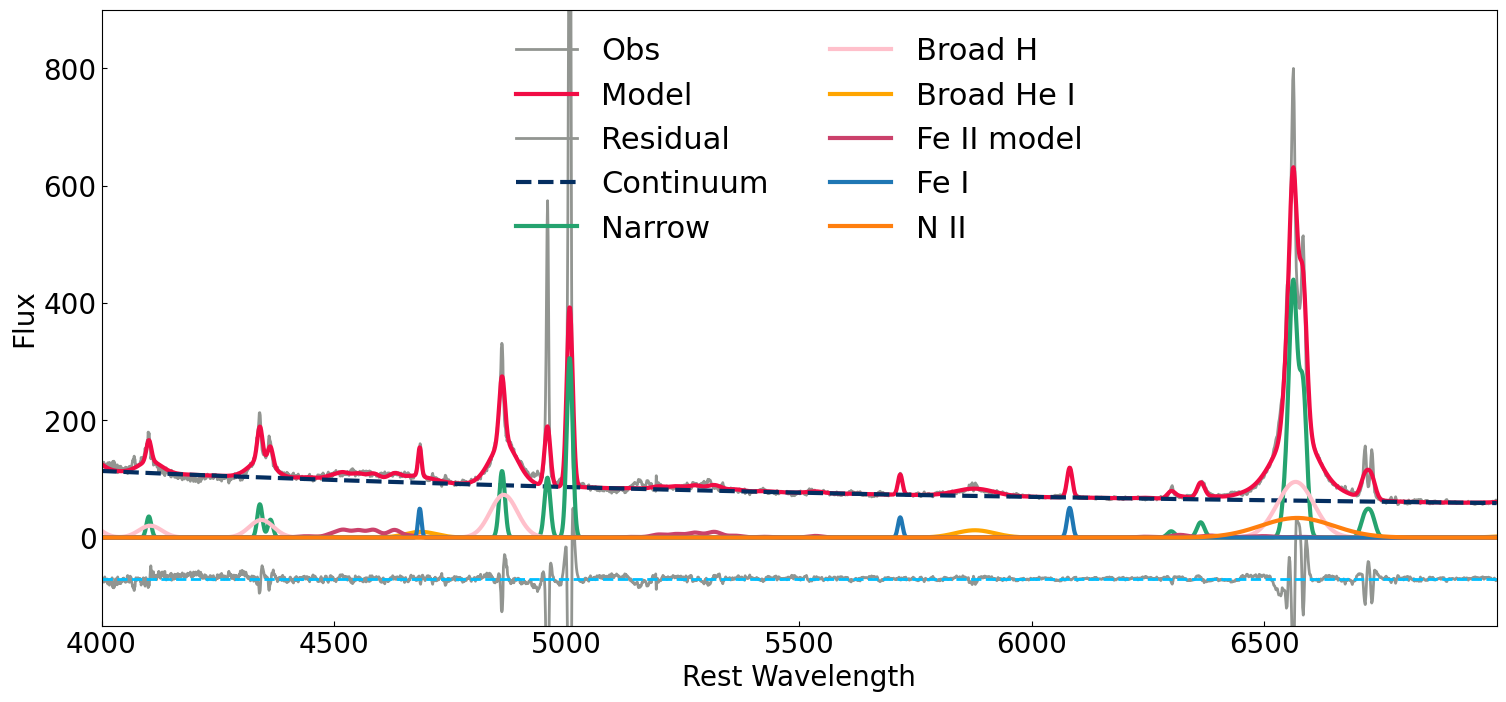

In [36]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="pink")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, feii(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)
plt.plot(s.wave, fei_1(s.wave)+fei_2(s.wave)+fei_3(s.wave),'-',label='Fe I', lw=3)
plt.plot(s.wave, nii_1(s.wave)+nii_2(s.wave),'-',label='N II', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.xlim(4000,7000)
plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

#plt.savefig('fantasy_fit.pdf')

In [37]:
model

<BinaryOpModel model instance '(((((((((brokenpowerlaw + br) + (((((((((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[OII]_3726) + nr_[OII]_3728) + nr_[NeIII]_3868) + nr_[OIII]_4363) + nr_[OI]_6300) + nr_[OI]_6363) + nr_[SII]_6716) + nr_[SII]_6730) + nr_[OII]_7330) + nr_Heps_3970) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861) + nr_Ha_6562)) + he) + NII6548) + NII6583) + FeI4685) + FeI5717) + FeI6081) + feii)'>

In [38]:
s.gres.format()

'Method                = levmar\nStatistic             = chi2\nInitial fit statistic = 48629.4\nFinal fit statistic   = 47850.8 at function evaluation 2086\nData points           = 2656\nDegrees of freedom    = 2584\nProbability [Q-value] = 0\nReduced statistic     = 18.5181\nChange in statistic   = 778.568\n   brokenpowerlaw.refer   5690         +/- 110.138     \n   brokenpowerlaw.ampl   73.437       +/- 1.66824     \n   brokenpowerlaw.index1   -1.23645     +/- 0.0119146   \n   brokenpowerlaw.index2   0.165251     +/- 0.0228744   \n   br.amp_Heps_3970   22.2321      +/- 0.935459    \n   br.amp_Hd_4102   20.2298      +/- 0.97714     \n   br.amp_Hg_4340   30.0262      +/- 1.19553     \n   br.amp_Hb_4861   72.8459      +/- 0.845566    \n   br.amp_Ha_6563   94.941       +/- 2.88525     \n   br.offs_kms    229.443      +/- 10.9641     \n   br.fwhm        4230.29      +/- 40.92       \n   nr_OIII5007.ampl   306.7        +/- 2.46236     \n   nr_OIII5007.offs_kms   0            +/- 1.59692   

In [39]:
results = pd.DataFrame()
results.index = s.gres.parnames
results['values'] = s.gres.parvals

results.index

Index(['brokenpowerlaw.refer', 'brokenpowerlaw.ampl', 'brokenpowerlaw.index1',
       'brokenpowerlaw.index2', 'br.amp_Heps_3970', 'br.amp_Hd_4102',
       'br.amp_Hg_4340', 'br.amp_Hb_4861', 'br.amp_Ha_6563', 'br.offs_kms',
       'br.fwhm', 'nr_OIII5007.ampl', 'nr_OIII5007.offs_kms',
       'nr_OIII5007.fwhm', 'nr_NII6584.ampl', 'nr_[OII]_3726.ampl',
       'nr_[OII]_3728.ampl', 'nr_[NeIII]_3868.ampl', 'nr_[OIII]_4363.ampl',
       'nr_[OI]_6300.ampl', 'nr_[OI]_6363.ampl', 'nr_[SII]_6716.ampl',
       'nr_[SII]_6730.ampl', 'nr_[OII]_7330.ampl', 'nr_Heps_3970.ampl',
       'nr_Hd_4101.ampl', 'nr_Hg_4340.ampl', 'nr_Hb_4861.ampl',
       'nr_Ha_6562.ampl', 'he.amp_HeI_4144', 'he.amp_HeI_4471',
       'he.amp_HeII_4686', 'he.amp_HeI_5877', 'he.amp_HeI_7065',
       'he.amp_HeI_7281', 'he.amp_HeI_7816', 'he.offs_kms', 'he.fwhm',
       'NII6548.ampl', 'NII6548.offs_kms', 'NII6548.fwhm', 'NII6583.ampl',
       'NII6583.offs_kms', 'NII6583.fwhm', 'FeI4685.ampl', 'FeI4685.offs_kms',
       '

### Narrow and Broad lines

In [40]:
print("Narrow lines:\n"
      + "Line flux in narrow Hb is {:.2f}".format(results.loc["nr_Hb_4861.ampl", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$"
      + "\nLine flux in narrow Ha is {:.2f}".format(results.loc["nr_Ha_6562.ampl", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$"
      + "\nLine flux in narrow [OIII] is {:.2f}".format(results.loc["nr_OIII5007.ampl", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$"
      + "\nLine fluxes for narrow [NII] are {:.2f}".format(results.loc["NII6548.ampl", "values"])
      + " and {:.2f}".format(results.loc["NII6583.ampl", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$ for 6548 and 6583 $\angstrom$ respectively."
      + "\nLine fluxes for narrow [SII] are {:.2f}".format(results.loc["nr_[SII]_6716.ampl", "values"])
      + " and {:.2f}".format(results.loc["nr_[SII]_6730.ampl", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$ for 6716 and 6730 $\angstrom$ respectively."
      )

Narrow lines:
Line flux in narrow Hb is 113.64 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$
Line flux in narrow Ha is 409.88 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$
Line flux in narrow [OIII] is 306.70 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$
Line fluxes for narrow [NII] are 33.49 and 0.00 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$ for 6548 and 6583 $\angstrom$ respectively.
Line fluxes for narrow [SII] are 33.97 and 36.01 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$ for 6716 and 6730 $\angstrom$ respectively.


In [41]:
print("Broad lines:\n"
      + "Line flux in broad Hb is {:.2f}".format(results.loc["br.amp_Hb_4861", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$"
      + "\nLine flux in narrow Ha is {:.2f}".format(results.loc["br.amp_Ha_6563", "values"]) + r" $10^{-7}$ erg / s / cm$^2$ / $\angstrom$"
)

Broad lines:
Line flux in broad Hb is 72.85 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$
Line flux in narrow Ha is 94.94 $10^{-7}$ erg / s / cm$^2$ / $\angstrom$


### BPT diagram

The spread of emission-line galaxies SDSS on the line ratio diagnostic diagram of Baldwin, Phillips & Terlevich (1981, PASP, 93, 5):

<img src="http://www.eso.org/~rfosbury/research/AGN2-07/exampleBPT.jpg">

Text(0.5, 1.0, 'Position on BPT')

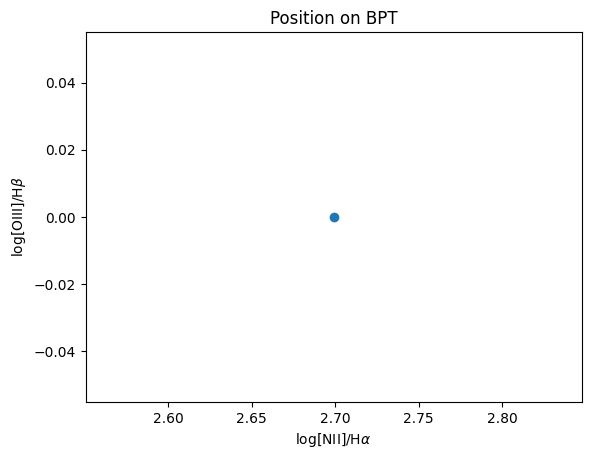

In [42]:
plt.scatter(x=results.loc["nr_OIII5007.ampl", "values"]/results.loc["nr_Hb_4861.ampl", "values"],
            y=results.loc["NII6583.ampl", "values"]/results.loc["nr_Ha_6562.ampl", "values"]
            )
plt.xlabel(r"log[NII]/H$\alpha$")
plt.ylabel(r"log[OIII]/H$\beta$")
plt.title("Position on BPT")

### Ha/Hb ratio in observed vs host corrected

In [43]:
s.restore()
s.crop(3800, 8000)

In [44]:
# lines added to the model based on https://physics.nist.gov/PhysRefData/ASD/lines_form.html

cont = continuum(s,min_refer=5690, refer=5700, max_refer=5710)

In [45]:
model = cont+broad+narrow+he+nii_1+nii_2+fei_1+fei_2+fei_3+feii

s.fit(model, ntrial=2)

stati 192004.8820721854
1 iter stat:  266.00945078006043
2 iter stat:  160.01497732026473


In [47]:
results_obs = pd.DataFrame()
results_obs.index = s.gres.parnames
results_obs['values'] = s.gres.parvals

In [49]:
print("Line ratio before host correction: {:.2f}".format(results_obs.loc["nr_Ha_6562.ampl", "values"]/results_obs.loc["nr_Hb_4861.ampl", "values"])
      + "\nLine ratio after host correction: {:.2f}".format(results.loc["nr_Ha_6562.ampl", "values"]/results.loc["nr_Hb_4861.ampl", "values"]))

Line ratio before host correction: 3.81
Line ratio after host correction: 3.61


The line ratio remains almost similar.

### A comment on FANTASY package:

Adding ability to reassign and save fantasy spectrum objects instead of doing restore() everytime would allow users to try different combinations of analysis with less computational power.